### PCA and Clustering

In [1]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *
from copy import *

%load_ext autoreload
%autoreload 2

In [2]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 20 # change to set one

In [3]:
# filter data with the minimum reviews
filtered_avis = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_avis)

11201 10549
1300 1341
963 1221
925 1200
918 1198
917 1196
916 1192
913 1190


In [4]:
# not centered version 
user_game_ratings.shape

(913, 1190)

In [5]:
# first choose the most popular game categories NO CAPITALIZE
categories = jeux_clean["Type"].str.split('|').dropna()
lst_categories = np.unique([item.strip() for list_items in categories for item in list_items])

In [6]:
# for each categories the number of games
count_cat = np.array([[category, int(jeux_clean['Type'].str.contains(category, na=False, regex=False).sum())] for category in lst_categories])
# two best categories
sorted_categ = count_cat[count_cat[:,1].astype(int).argsort()[::-1]]
sorted_categ

array([['Jeux de plateau', '3163'],
       ['Jeux de cartes', '1742'],
       ['Jeux de guerre', '444'],
       ['Affrontement', '427'],
       ['Autres', '397'],
       ['Placement', '396'],
       ['Gestion', '395'],
       ['Médiéval', '379'],
       ['Hasard (Dé, Cartes, ...)', '363'],
       ['Jeux de figurines', '301'],
       ['Casse-tête', '297'],
       ['Combinaison', '263'],
       ['Déplacement', '257'],
       ['Ambiance', '250'],
       ['Jeux de pions', '244'],
       ['Médiéval-fantastique', '239'],
       ['Dés', '232'],
       ['Guerre', '226'],
       ['Coopération', '210'],
       ['Gestion de main', '204'],
       ['Exploration', '185'],
       ['Animaux', '185'],
       ['Jeu de carte à collectionner', '184'],
       ['Jeux de connaissances', '180'],
       ['Bluff', '179'],
       ['Fantastique', '172'],
       ['Majorité', '161'],
       ['Jeux de dés', '160'],
       ['Jeu de logique', '157'],
       ['Science fiction', '153'],
       ['Prise de risque', '153']

In [7]:
# for each cat, the game ids for sorted df
jeux_nonan = jeux_clean.dropna()
jeux_nonan = jeux_nonan[jeux_nonan["Game id"].isin(filtered_avis["Game id"].unique())] # games concerned from filtered df

# for each categories, the list of games associated to the tag
cat_games = [[cat, list(jeux_nonan.loc[jeux_nonan['Type'].str.lower().str.contains(cat.lower(), na=False, regex=False)]["Game id"])] for cat in lst_categories]
array_cat_games = np.array(cat_games, dtype=object)[:,1] # list of games id 

In [8]:
# associated index game
game_ids = pd.Series(np.unique(np.concatenate(array_cat_games)).astype(int)) # game ids concerned for matrix
# associated index users 
users_id = pd.Series(np.unique(filtered_avis["User id"]))
game_ids.shape, users_id.shape


((886,), (913,))

In [9]:
# using pivot table -> separate cat1|cat2...|catn into many rows, after counting the categories

# merge the databases jeux and avis
avis_jeux = jeux_nonan[["Game id", "Type"]].merge(filtered_avis[["User id", "Game id", "Rating"]], on='Game id')

# for each category create a new row
types = avis_jeux['Type'].str.split('|').explode()
user_game_type = pd.DataFrame({
    'User id': avis_jeux['User id'].repeat(avis_jeux['Type'].str.split('|').apply(len)),
    'Game id': avis_jeux['Game id'].repeat(avis_jeux['Type'].str.split('|').apply(len)),
    'Type': types
})


3 matrix:
- user type count : users and categories, x the number of games of this category user rated, normalised
- user type: users and categories, 1 if rated a game of this category else 0
- game type: games and categories, 1 if the game belongs to this categories else 0, normalized by nb time tags appears

Clustering:
- Hierarchichal clustering
- Bi/Co clustering, clustering based on rows and columns, observe silhouette score

---
User type count matrix

In [10]:
# create pivot table: rows users, columns categories, x number of reviewed game of user of this categ, else 0, normalised
user_type_count = user_game_type[["User id", "Type"]].pivot_table(index ="User id", columns="Type", aggfunc='size', fill_value=0)
user_type_count = user_type_count.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
user_type_count = user_type_count.div(user_type_count.sum(axis=1), axis=0)

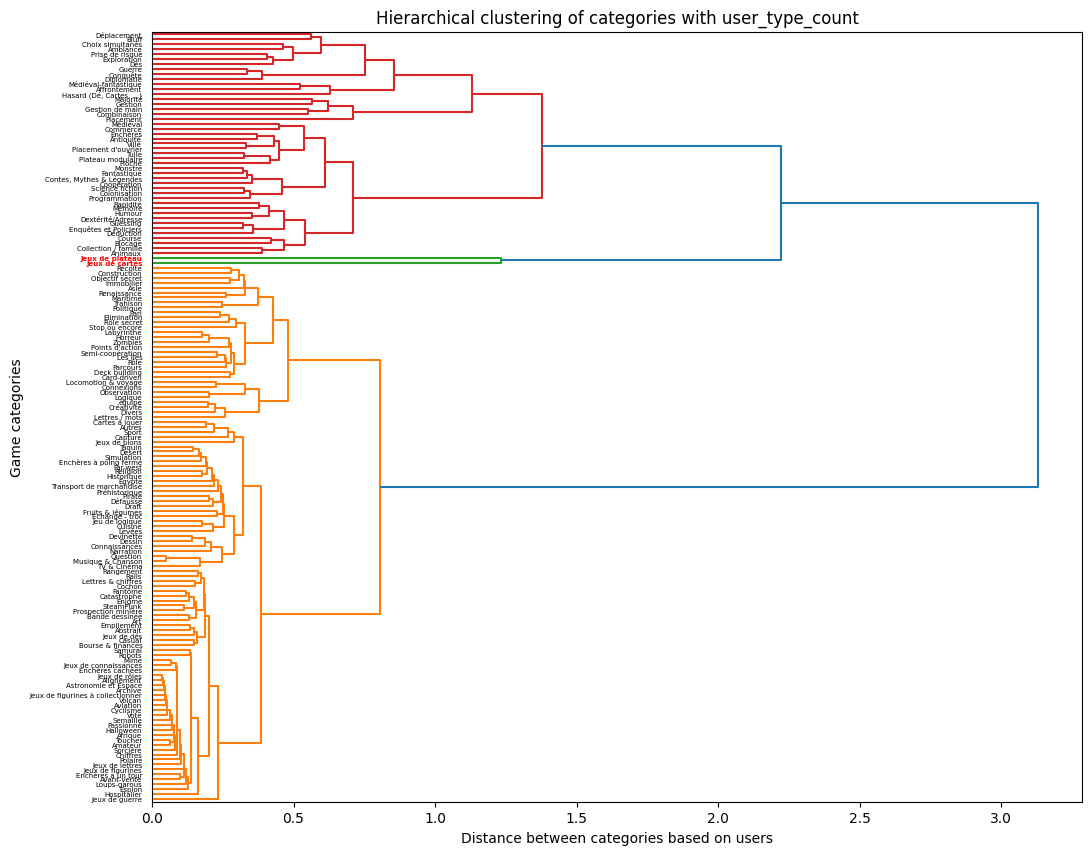

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

# dendogram clustering
# figures
plt.figure(figsize=(12,10))
Y = linkage(user_type_count.T, method='ward') # clustering the categories 
_ = dendrogram(Y, orientation='right', labels=user_type_count.columns) 
plt.title("Hierarchical clustering of categories with user_type_count")
plt.ylabel('Game categories')
plt.xlabel('Distance between categories based on users')

# highlight specific labels
highlight_labels = ['Jeux de plateau', 'Jeux de cartes']

for label in plt.gca().get_ymajorticklabels():
    if label.get_text() in highlight_labels:
        label.set_color('red')
        label.set_fontweight('bold')

plt.show()

cluster  1
Index(['Abstrait', 'Afrique', 'Alignement', 'Amateur', 'Archive', 'Art',
       'Asie', 'Astronomie et Espace', 'Autres', 'Avant-vente',
       ...
       'Stop ou encore', 'TV & Cinéma', 'Taquin', 'Toucher', 'Trahison',
       'Transport de marchandise', 'Volcan', 'Vote', 'Zombies', 'équipe'],
      dtype='object', name='Type', length=108)
cluster  2
Index(['Affrontement', 'Ambiance', 'Animaux', 'Antiquité', 'Blocage', 'Bluff',
       'Choix simultanés', 'Collection / famille', 'Colonisation',
       'Combinaison', 'Commerce', 'Conquête', 'Contes, Mythes & Légendes',
       'Coopération', 'Course', 'Dextérité/Adresse', 'Diplomatie', 'Déduction',
       'Déplacement', 'Dés', 'Enchères', 'Enquêtes et Policiers',
       'Exploration', 'Fantastique', 'Gestion', 'Gestion de main', 'Guerre',
       'Guessing', 'Hasard (Dé, Cartes, ...)', 'Humour', 'Majorité', 'Monstre',
       'Médiéval', 'Médiéval-fantastique', 'Mémoire', 'Pioche', 'Placement',
       'Placement d'ouvrier', 'Pla

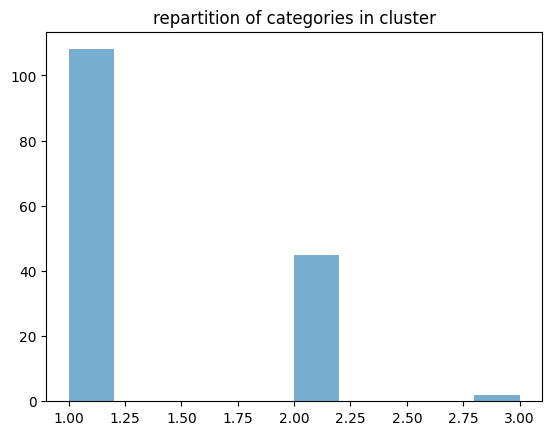

In [12]:
# Hierarchical clustering : cluster categories with user-categories-count
from scipy.cluster.hierarchy import fcluster

linkage_matrix = linkage(user_type_count.T, method='ward', optimal_ordering=True)
fl = fcluster(linkage_matrix,3,criterion='maxclust')
plt.title("repartition of categories in cluster")
plt.hist(fl, alpha = 0.6)

for i in range(1, 4):
    print("cluster ", i)
    print(user_type_count.T.index[np.where(fl == i)[0]])

# we get the popular categories amongs users

In [ ]:
# silhouette score evaluation user_type_count.T
scores = [silhouette_score(user_type_count.T,fcluster(linkage(user_type_count.T, method='ward'),i,criterion='maxclust')) for i in range(2,10)]
scores

[0.3997354111187616,
 0.3931684169297576,
 0.32577043092849317,
 0.3256686881614058,
 0.3318810427116588,
 0.3341641027549612,
 0.16091775656488355,
 0.1652858695461154]

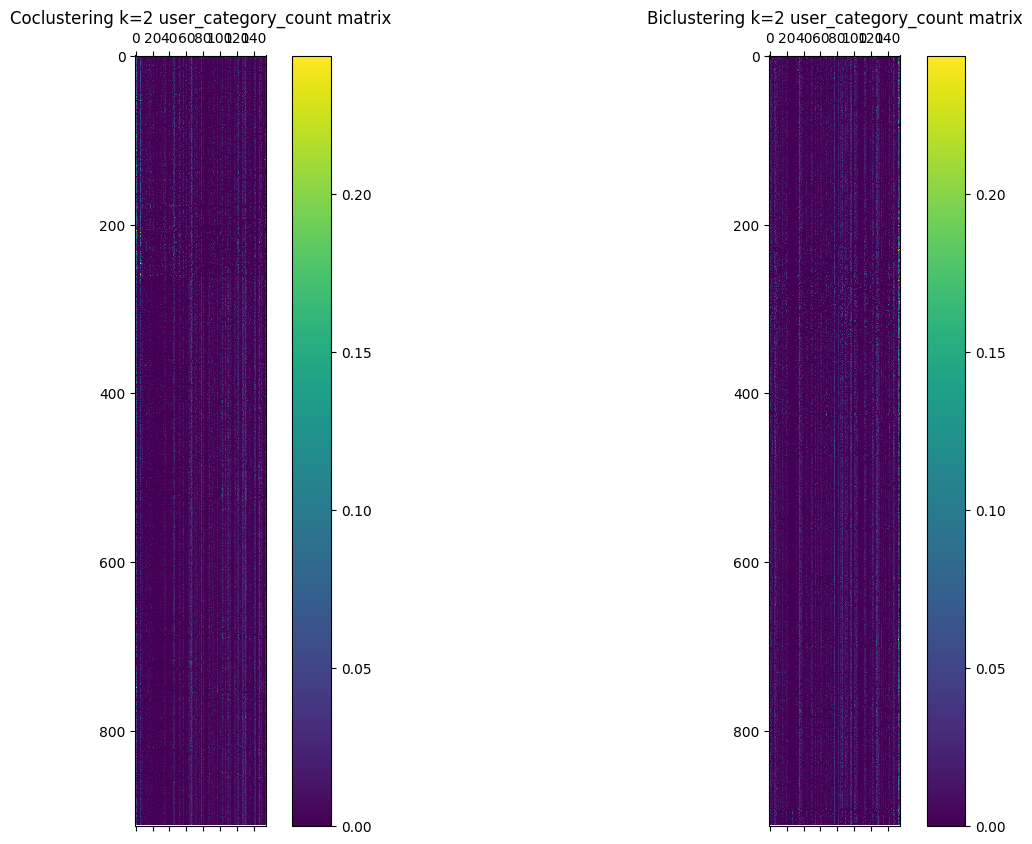

In [21]:
# Bi/Coclustering visualisation
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering

fig, ax = plt.subplots(1,2, figsize=(15, 10))

# Co clustering
clustering = SpectralCoclustering(n_clusters=2, random_state=0).fit(user_type_count)
# group the clusters
reordered_rows = user_type_count.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[0].matshow(reordered_data)
ax[0].set_title("Coclustering k=2 user_category_count matrix")
fig.colorbar(cax, ax=ax[0])

# Bi clustering
clustering = SpectralBiclustering(n_clusters=2, random_state=0).fit(user_type_count)
# group the clusters
reordered_rows = user_type_count.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[1].matshow(reordered_data)
ax[1].set_title("Biclustering k=2 user_category_count matrix")
fig.colorbar(cax, ax=ax[1])

plt.subplots_adjust() 
plt.show()

In [33]:
# silhouette score evaluation user_type_count, co clustering
scores_users_tags = [
    (silhouette_score(user_type_count, model.row_labels_), silhouette_score(user_type_count.T, model.column_labels_)) for i in range(2, 10) for model in [SpectralCoclustering(n_clusters=i, random_state=0).fit(user_type_count)]]
scores_users_tags


[(0.13707278850073093, 0.016627116639819844),
 (0.09625496067552065, -0.06051256202979226),
 (0.03305433696480599, -0.12613858011780135),
 (0.024587632072025963, -0.11788132964732127),
 (0.02232947106719148, -0.1480001990604927),
 (0.02473829370200036, -0.1626403641696672),
 (0.02640386723230941, -0.16767185402543636),
 (0.018417254987447593, -0.25446062912328504)]

In [ ]:
# silhouette score evaluation user_type_count, bi clustering
scores_users_tags = [
    (silhouette_score(user_type_count, model.row_labels_), silhouette_score(user_type_count.T, model.column_labels_)) for i in range(2, 10) for model in [SpectralBiclustering(n_clusters=i, random_state=0).fit(user_type_count)]]
scores_users_tags

[(0.1351529770907609, 0.729212946321016),
 (0.03493208716660942, 0.21769986260010127),
 (0.04062254339885419, 0.18327288138897277),
 (-0.00495504036069146, 0.15598025825851894),
 (0.004290493008279754, 0.05978612760437077),
 (-0.017637036370873334, 0.07334709931239573),
 (-0.024863035175886138, 0.056735224235924385),
 (-0.020099744652073207, 0.01311184816959867)]

In [44]:

# clustering = SpectralCoclustering(n_clusters=3, random_state=0).fit(user_type_count)
# user_type_count.index[clustering.row_labels_ == 0], user_type_count.index[clustering.row_labels_ == 1], user_type_count.index[clustering.row_labels_ == 2]

After Biclustering the users, we look at the game tags these users rated -> obtained same prop for each cluster

In [45]:
# bi/coclustering visualise tags frequency among game clusters 
# Nclus = 7
# clustering = SpectralCoclustering(n_clusters=Nclus, random_state=0).fit(user_type_count) 

# fig, axes = plt.subplots(3, 3, figsize=(13, 8))
# clust = 0
# for i in range(3):
#     for j in range(3):
#         if clust >= Nclus:
#             break
        
#         ax = axes[i, j]  # Get the axis for each subplot
        
#         # Filter the DataFrame (clust)
#         cluster_cat = user_type_count.loc[:, (user_type_count.loc[user_type_count.index[np.where(clustering.row_labels_ == clust)]]!= 0).any(axis=0)]
#         print(cluster_cat.shape)
#         # Calculate the frequency of tags in the current cluster
#         pop_tags = ["Jeux de plateau", "Jeux de cartes", "Hasard (Dé, Cartes, ...)", "Placement", "Affrontement", "Combinaison"]
#         cluster_cat = cluster_cat.drop(columns=pop_tags, errors='ignore')
#         tag_frequency = (cluster_cat != 0).sum(axis=0) / (cluster_cat != 0).sum().sum()

#         # Plot the frequency
#         tag_frequency.nlargest(10).plot(kind='barh', color='skyblue', ax=ax)
        
#         ax.set_title(f'Frequency of tags in game cluster {clust}', fontsize=10)
#         ax.set_xlabel('Frequency', fontsize=8) 
#         ax.set_ylabel('Tags', fontsize=8)
#         ax.tick_params(axis='both', which='major', labelsize=7)
#         ax.set_xticks(ax.get_xticks())

#         clust += 1

# plt.tight_layout()
# plt.show()

---
User type matrix

In [26]:
# create pivot table: rows users, columns categories, 1 if user reviewed game of this categ, else 0
user_type = user_game_type[["User id", "Type"]].drop_duplicates().pivot_table(index ="User id", columns="Type", aggfunc='size', fill_value=0)

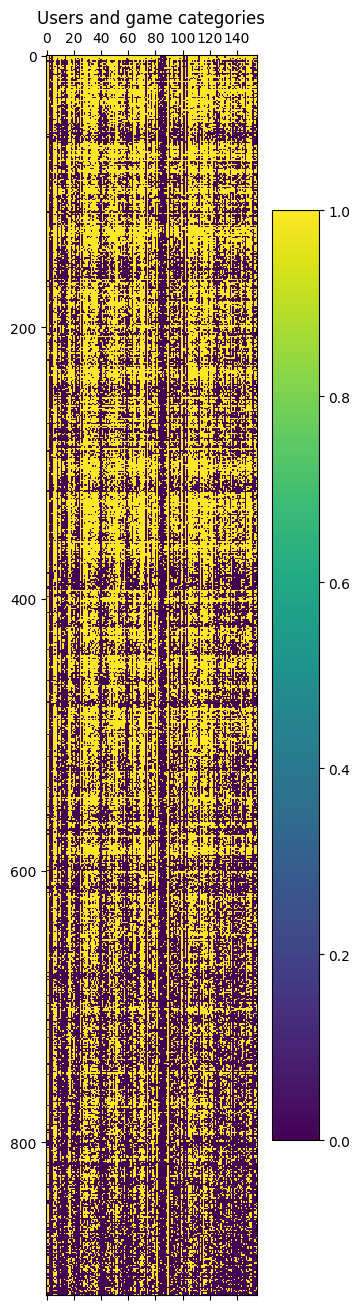

In [47]:
plt.matshow(user_type)
plt.title("Users and game categories")
plt.colorbar()

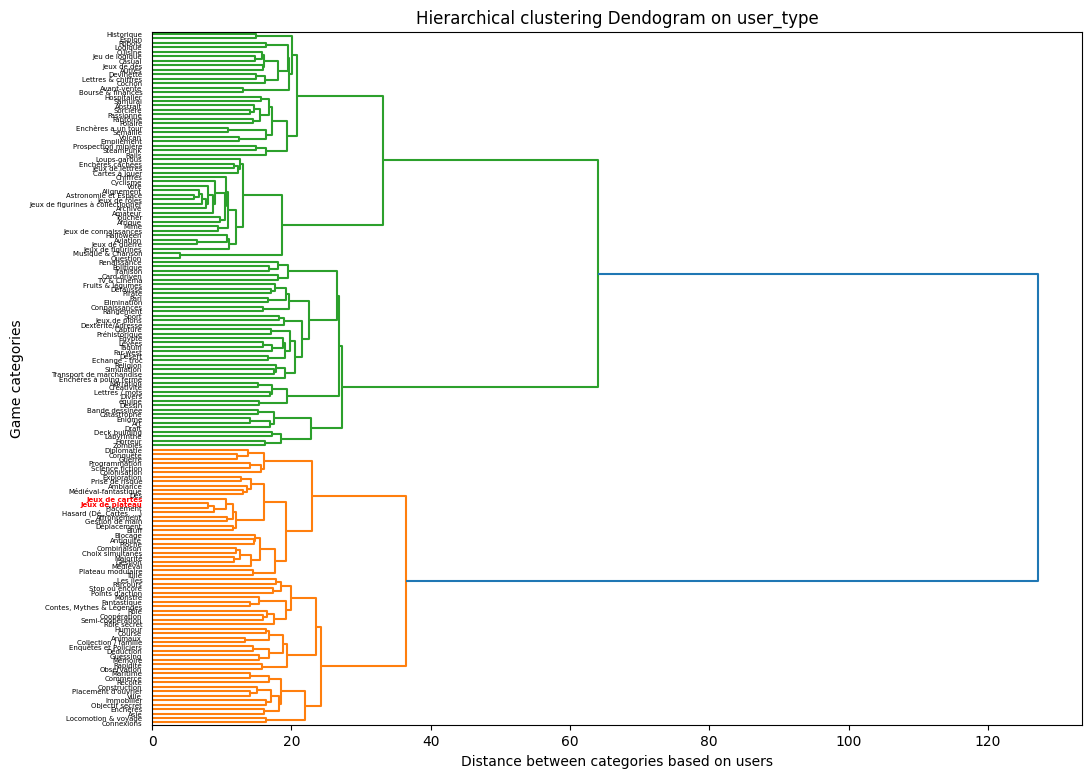

In [27]:
from scipy.cluster.hierarchy import linkage, dendrogram
# hierarchical clustering on user_type
# check the different methods
linkage_matrix=linkage(user_type.T,method='ward', optimal_ordering=True)

plt.figure(figsize=(12,9))
dend = dendrogram(linkage_matrix, labels=user_type.head(200).columns, leaf_font_size=5, orientation="right")
plt.title("Hierarchical clustering Dendogram on user_type")
plt.ylabel('Game categories')
plt.xlabel('Distance between categories based on users')

# highlight specific labels
highlight_labels = ['Jeux de plateau', 'Jeux de cartes']

for label in plt.gca().get_ymajorticklabels():
    if label.get_text() in highlight_labels:
        label.set_color('red')
        label.set_fontweight('bold')

plt.show()

In [34]:
# silhouette score evaluation user_type hirarchical
scores = [silhouette_score(user_type.T,fcluster(linkage(user_type.T, method='ward'),i,criterion='maxclust')) for i in range(2,10)]
scores

[0.22538460423128598,
 0.15322803517603265,
 0.09943877699845317,
 0.046651265616083425,
 0.04966028302685994,
 0.052792696918292366,
 0.055990348071686374,
 0.05594776775042248]

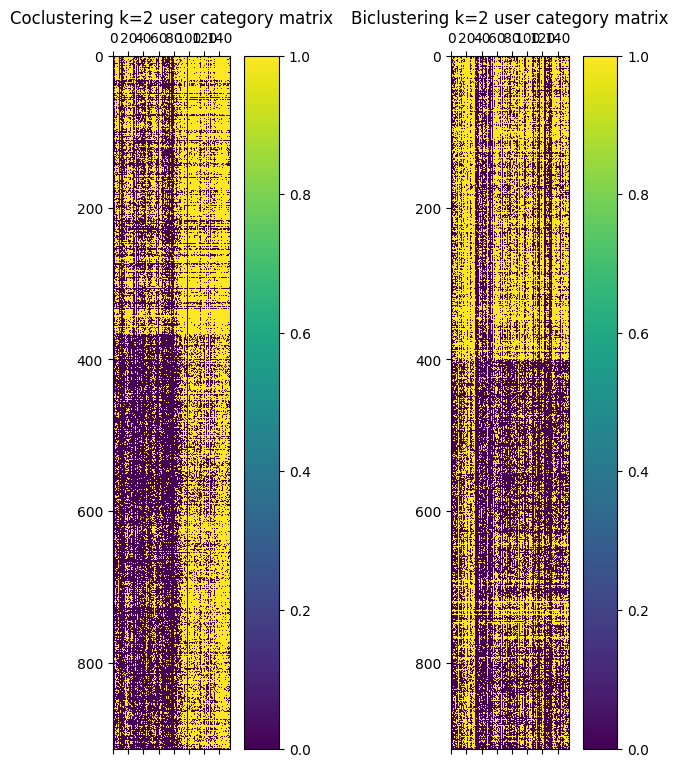

In [35]:
# bi/co clustering user_type
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering

fig, ax = plt.subplots(1,2, figsize=(8, 9))

# Co clustering
clustering = SpectralCoclustering(n_clusters=2, random_state=0).fit(user_type)
# group the clusters
reordered_rows = user_type.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[0].matshow(reordered_data)
ax[0].set_title("Coclustering k=2 user category matrix")
fig.colorbar(cax, ax=ax[0])

# Bi clustering
clustering = SpectralBiclustering(n_clusters=2, random_state=0).fit(user_type)
# group the clusters
reordered_rows = user_type.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[1].matshow(reordered_data)
ax[1].set_title("Biclustering k=2 user category matrix")
fig.colorbar(cax, ax=ax[1])

plt.subplots_adjust() 
plt.show()

In [36]:
# silhouette score evaluation user_type, co clustering
scores_users_tags = [
    (silhouette_score(user_type, model.row_labels_), silhouette_score(user_type.T, model.column_labels_)) for i in range(2, 10) for model in [SpectralCoclustering(n_clusters=i, random_state=0).fit(user_type)]]
scores_users_tags

[(0.07886582469935036, 0.1842128823589268),
 (0.06564484906042119, 0.07170165093131631),
 (0.049281000027091015, -0.010770893327456298),
 (0.035856853503675575, -0.00485286745311267),
 (0.029273082644178862, -0.020167244624155062),
 (0.018629953251753144, -0.040624581241037835),
 (0.01100927287976494, -0.049596086920199824),
 (0.005622963755930907, -0.06651535976505712)]

In [37]:
# silhouette score evaluation user_type, bi clustering
scores_users_tags = [
    (silhouette_score(user_type, model.row_labels_), silhouette_score(user_type.T, model.column_labels_)) for i in range(2, 10) for model in [SpectralBiclustering(n_clusters=i, random_state=0).fit(user_type)]]
scores_users_tags

[(0.09644430756395007, 0.014098873745423417),
 (0.06450565856557122, -0.10545891942923082),
 (0.057586124947142034, -0.11462589515910532),
 (0.04736235140008178, -0.11393758730436332),
 (0.03218795391253499, -0.1239413560220299),
 (0.03134188139535588, -0.13545293314338303),
 (0.013635379724834277, -0.1426288532880977),
 (-0.0012488769115763538, -0.14232812412119042)]

Hierarchical clustering on users and categories


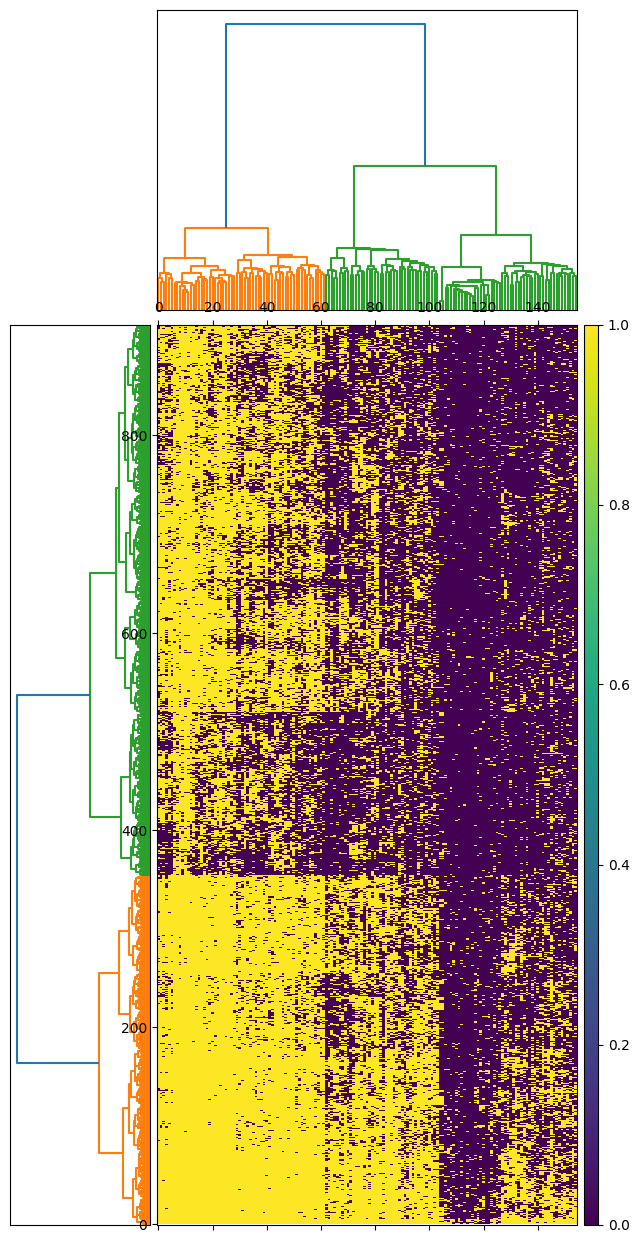

In [50]:
# Clustering using dendograms user_type 
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
from scipy.cluster.hierarchy import linkage, dendrogram

# figures
fig = plt.figure(figsize=(7, 15))

ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = linkage(user_type, method='ward') # lcustering the users 
Z1 = dendrogram(Y, orientation='left') 
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
Y = linkage(user_type.T, method='ward') # clustering the categories 
Z2 = dendrogram(Y)
ax2.set_xticks([])
ax2.set_yticks([])

axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = user_type.iloc[:,idx2]
D = D.iloc[idx1,:]
im = axmatrix.matshow(D, aspect='auto', origin='lower')

axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
plt.colorbar(im, cax=axcolor)
print("Hierarchical clustering on users and categories")
plt.show()

cluster  1
Index(['Animaux', 'Asie', 'Collection / famille', 'Commerce', 'Connexions',
       'Construction', 'Contes, Mythes & Légendes', 'Coopération', 'Course',
       'Déduction', 'Enchères', 'Enquêtes et Policiers', 'Fantastique',
       'Guessing', 'Humour', 'Immobilier', 'Les îles', 'Locomotion & voyage',
       'Maritime', 'Monstre', 'Mémoire', 'Objectif secret', 'Observation',
       'Parcours', 'Placement d'ouvrier', 'Points d'action', 'Rapidité',
       'Récolte', 'Rôle', 'Rôle secret', 'Semi-coopération', 'Stop ou encore',
       'Ville'],
      dtype='object', name='Type')
cluster  2
Index(['Affrontement', 'Ambiance', 'Antiquité', 'Blocage', 'Bluff',
       'Choix simultanés', 'Colonisation', 'Combinaison', 'Conquête',
       'Diplomatie', 'Déplacement', 'Dés', 'Exploration', 'Gestion',
       'Gestion de main', 'Guerre', 'Hasard (Dé, Cartes, ...)',
       'Jeux de cartes', 'Jeux de plateau', 'Majorité', 'Médiéval',
       'Médiéval-fantastique', 'Pioche', 'Placement', 'Pl

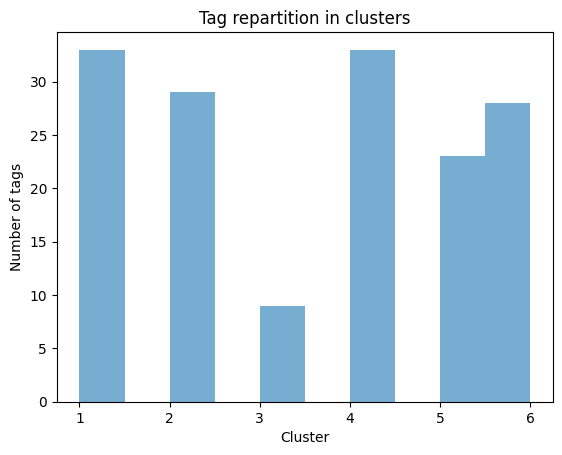

In [51]:
# visualise clusters from linkage, hierarchical clustering 
from scipy.cluster.hierarchy import fcluster

# Categories cluster with user-categories
linkage_matrix = linkage(user_type.T, method='ward', optimal_ordering=True)
fl = fcluster(linkage_matrix,6,criterion='maxclust')
plt.title("Tag repartition in clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of tags")
plt.hist(fl, alpha = 0.6)

for i in range(1, max(fl) + 1):
    print("cluster ", i)
    print(user_type.T.index[np.where(fl == i)[0]])

In [52]:
# visualise the clusters from coclustering
clustering = SpectralCoclustering(n_clusters=7, random_state=0).fit(user_type)
for i in np.unique(clustering.column_labels_):
    print('cluster ', i)
    print(user_type.T.index[np.where(clustering.column_labels_ == i)[0]])

cluster  0
Index(['Abstrait', 'Afrique', 'Amateur', 'Autres', 'Avant-vente',
       'Bourse & finances', 'Capture', 'Casual', 'Cuisine', 'Desert',
       'Echange - troc', 'Espion', 'Jeu de logique', 'Jeux de dés',
       'Jeux de lettres', 'Jeux de pions', 'Levées', 'Logique', 'Sport',
       'Toucher', 'Vote'],
      dtype='object', name='Type')
cluster  1
Index(['Archive', 'Astronomie et Espace', 'Bande dessinée', 'Catastrophe',
       'Connaissances', 'Coopération', 'Cyclisme', 'Deck building', 'Dessin',
       'Divers', 'Draft', 'Enquêtes et Policiers', 'Horreur', 'Hospitalier',
       'Labyrinthe', 'Narration', 'Passionné', 'Points d'action', 'Rôle',
       'Rôle secret', 'Semi-coopération', 'Zombies', 'équipe'],
      dtype='object', name='Type')
cluster  2
Index(['Affrontement', 'Card-driven', 'Choix simultanés', 'Colonisation',
       'Combinaison', 'Conquête', 'Construction', 'Contes, Mythes & Légendes',
       'Diplomatie', 'Dés', 'Enchères à poing fermé', 'Exploration',
   

Tags frequence depending of users clusters also don't show differences 

---
Game type matrix

In [38]:
game_type = user_game_type[["Game id", "Type"]].drop_duplicates().pivot_table(index ="Game id", columns="Type", aggfunc='size', fill_value=0)
game_type_old = game_type
tag_frequencies = game_type.sum(axis=0)  # Frequency of each tag across all games, to penalize popular tags
game_type = game_type.div(tag_frequencies, axis=1)

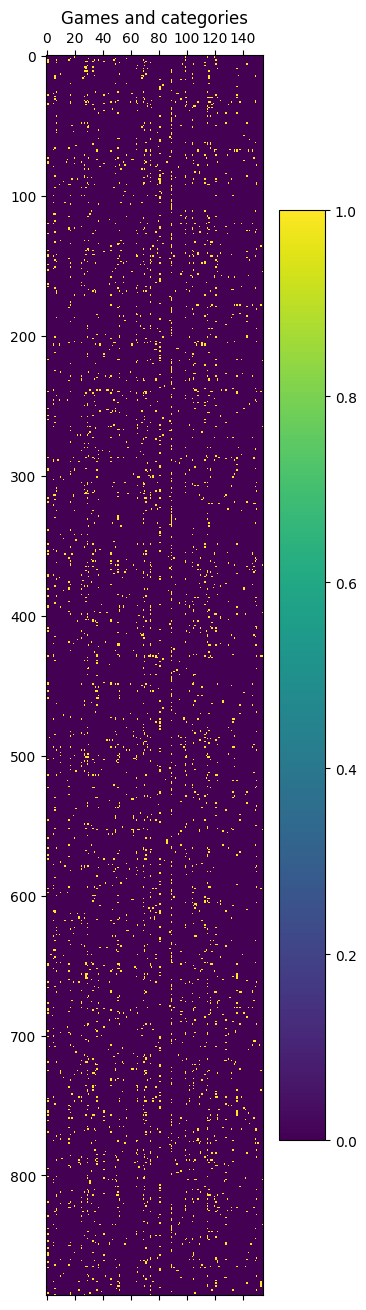

In [39]:
plt.matshow(game_type_old)
plt.title("Games and categories")
plt.colorbar()

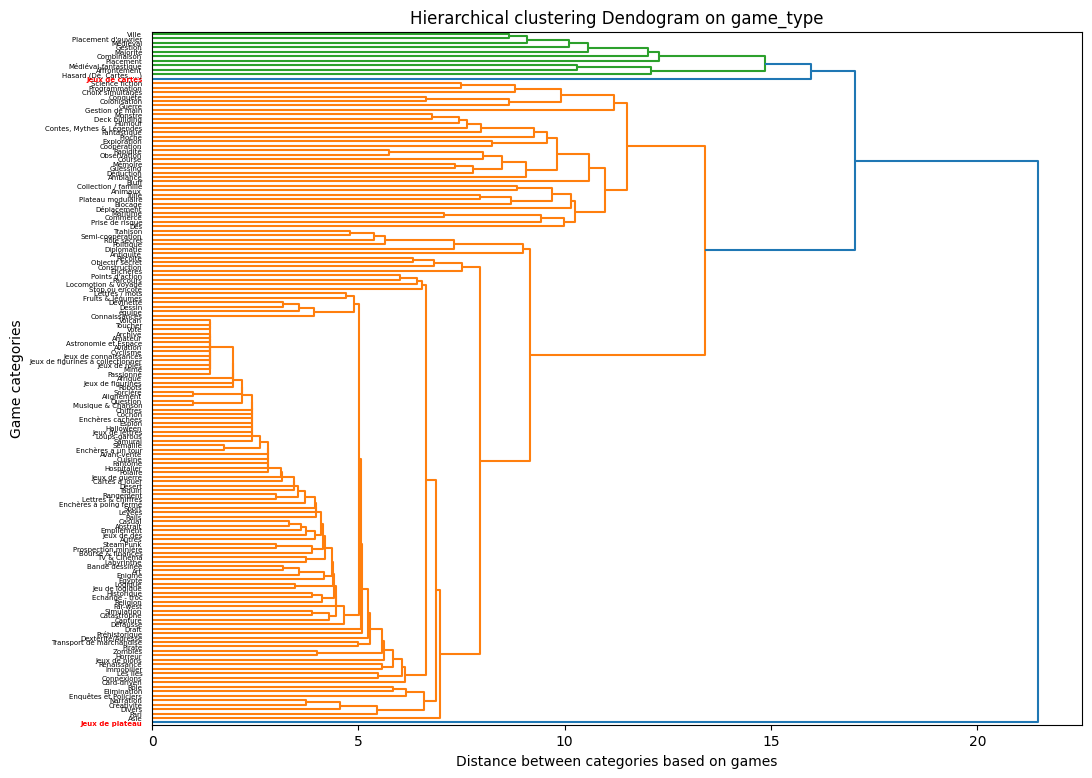

In [40]:
from scipy.cluster.hierarchy import linkage, dendrogram

# hierarchical clustering of categories
linkage_matrix=linkage(game_type_old.T,method='ward') #optimal_ordering=True

plt.figure(figsize=(12,9))
dendrogram(linkage_matrix, labels=game_type_old.head(200).columns, leaf_font_size=5, orientation="right")
plt.title("Hierarchical clustering Dendogram on game_type")
plt.ylabel('Game categories')
plt.xlabel('Distance between categories based on games')

# highlight specific labels
highlight_labels = ['Jeux de plateau', 'Jeux de cartes']

for label in plt.gca().get_ymajorticklabels():
    if label.get_text() in highlight_labels:
        label.set_color('red')
        label.set_fontweight('bold')

plt.show()

In [43]:
# silhouette score evaluation game_type, tags and game
scores = [(silhouette_score(game_type.T,fcluster(linkage(game_type.T, method='ward'),i,criterion='maxclust')), silhouette_score(game_type,fcluster(linkage(game_type, method='ward'),i,criterion='maxclust'))) for i in range(2,10)]
scores

[(0.4407762007396803, 0.8479377767110582),
 (0.44512636535204586, 0.847856543893123),
 (0.4478114975001622, 0.8343767292594461),
 (0.45052631998411025, 0.8349702296667847),
 (0.4532714285855718, 0.83553314306458),
 (0.456043472527469, 0.8356874728735895),
 (0.4588454275383119, 0.8346273070309163),
 (0.4616771300803548, 0.835135824643778)]

In [56]:
# hierarchical clustering, categories clusters with game-categories
# from scipy.cluster.hierarchy import fcluster
# linkage_matrix = linkage(game_type.T, method='ward', optimal_ordering=True)
# fl2 = fcluster(linkage_matrix,4,criterion='maxclust')
# plt.hist(fl2, alpha = 0.6)

# for i in range(1, max(fl2) + 1):
#     print("cluster ", i)
#     print(game_type.columns[np.where(fl2 == i)])

Tags clustering isolate not popular tags here

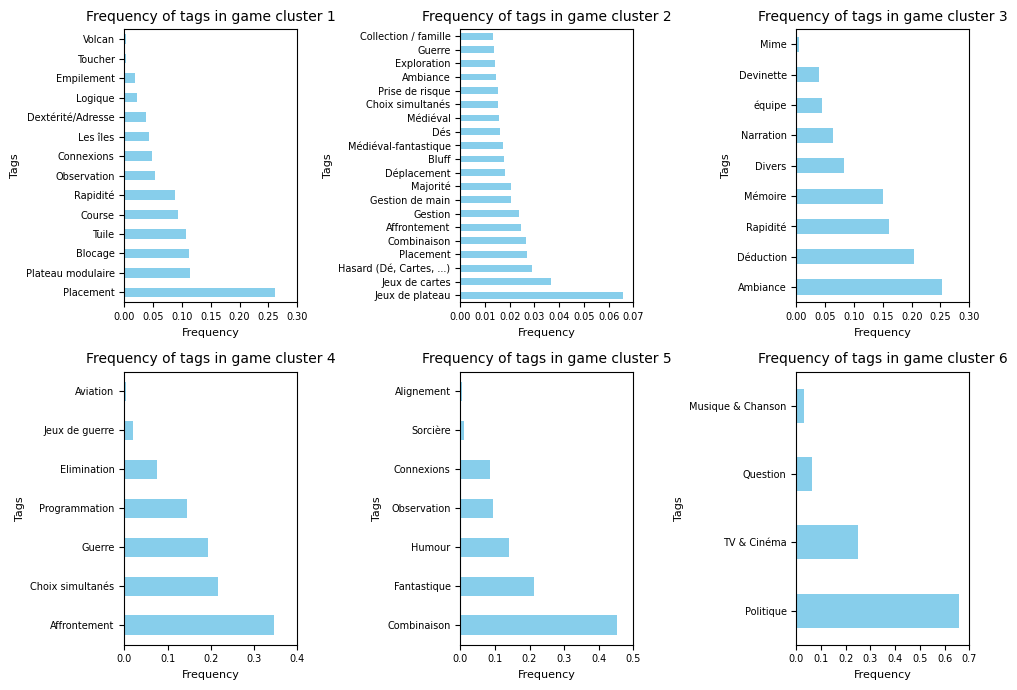

In [79]:
# hierarchical clustering, categories of clustered games with game-categories

linkage_matrix = linkage(game_type, method='ward')
fl2 = fcluster(linkage_matrix,6,criterion='maxclust')
# plt.title("Repartition of game in clusters")
# plt.hist(fl2, alpha = 0.6)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
clust = 1

for i in range(3):
    for j in range(3):
        if clust > max(fl2):
            break
        
        ax = axes[i, j]  # Get the axis for each subplot
        
        # Filter the DataFrame based on the current value of fl2 (clust)
        cluster_cat = game_type.loc[:, (game_type.loc[game_type.index[np.where(fl2 == clust)]] != 0).any(axis=0)] # tags of games in the cluster
        
        # Calculate the frequency of tags in the current cluster
        # most_pop_clusters = ["Jeux de plateau", "Jeux de cartes", "Hasard (Dé, Cartes, ...)", "Placement", "Affrontement", "Combinaison"]
        # cluster_cat = cluster_cat.drop(columns = most_pop_clusters, errors='ignore')
        
        tag_frequency = (cluster_cat != 0).sum(axis=0) / (cluster_cat != 0).sum().sum()

        # Plot the frequency of 10 largest (case too much tags)
        tag_frequency.nlargest(20).plot(kind='barh', color='skyblue', ax=ax) 
        
        # Set the title and axis labels with appropriate fontsize
        ax.set_title(f'Frequency of tags in game cluster {clust}', fontsize=10)
        ax.set_xlabel('Frequency', fontsize=8) 
        ax.set_ylabel('Tags', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.set_xticks(ax.get_xticks())

        clust += 1

plt.tight_layout()
plt.show()

Hierarchical clustering on games, then plot frequence of games' tag. We can see quite distinct clusters

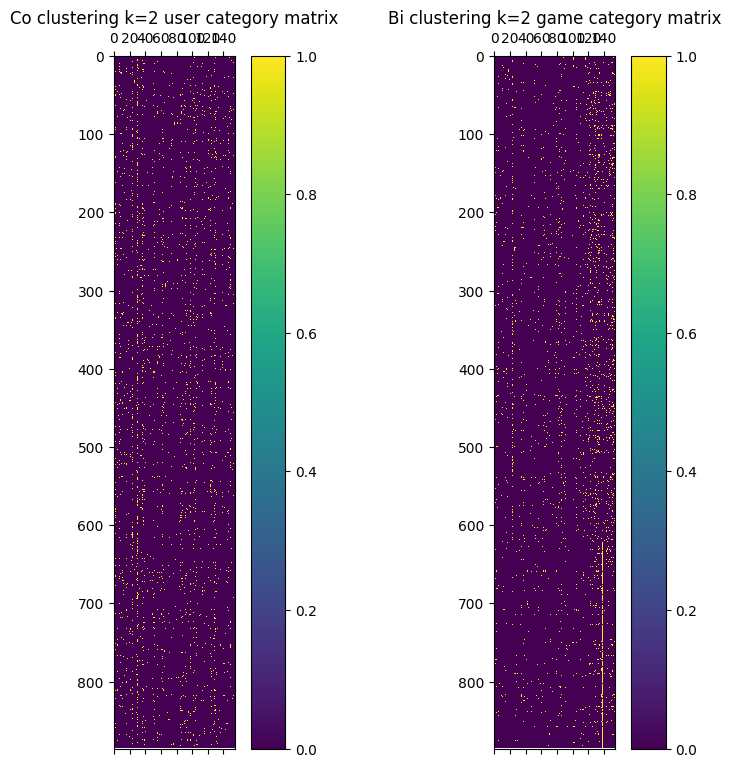

In [44]:
# bi/co clustering game_type
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
fig, ax = plt.subplots(1,2, figsize=(9, 9))

# Co clustering
clustering = SpectralCoclustering(n_clusters=2, random_state=0).fit(game_type_old)
# group the clusters
reordered_rows = game_type_old.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[0].matshow(reordered_data)
ax[0].set_title("Co clustering k=2 user category matrix")
fig.colorbar(cax, ax=ax[0])

# Bi clustering
clustering = SpectralBiclustering(n_clusters=2, random_state=0).fit(game_type_old)

# # group the clusters
reordered_rows = game_type_old.iloc[np.argsort(clustering.row_labels_)]
reordered_data = reordered_rows.iloc[:, np.argsort(clustering.column_labels_)]

cax = ax[1].matshow(reordered_data)
ax[1].set_title("Bi clustering k=2 game category matrix")

fig.colorbar(cax, ax=ax[1])
plt.subplots_adjust() 
plt.show()


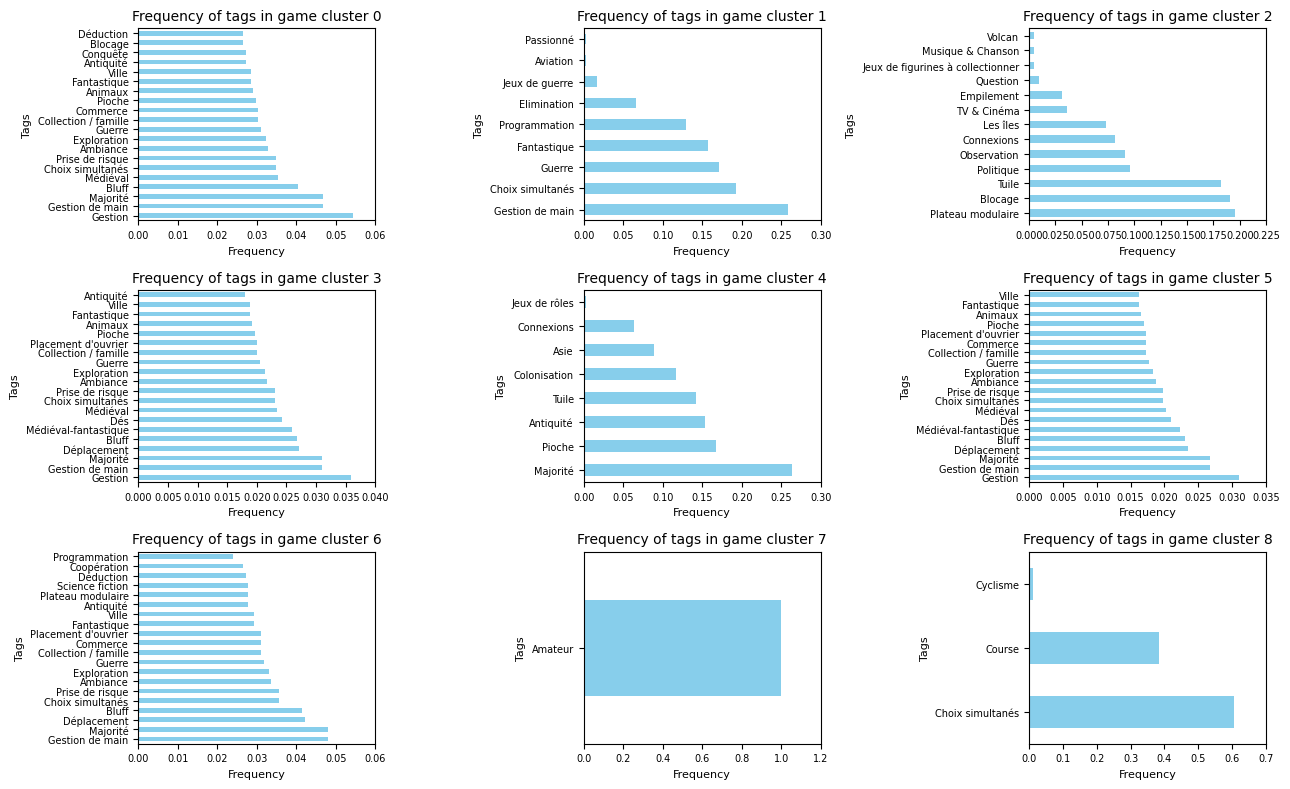

In [274]:
# bi/coclustering visualise tags frequency among game clusters 
Nclus = 9
clustering = SpectralBiclustering(n_clusters=Nclus, random_state=0).fit(game_type) # on the games!

fig, axes = plt.subplots(3, 3, figsize=(13, 8))
clust = 0
for i in range(3):
    for j in range(3):
        if clust >= Nclus:
            break
        
        ax = axes[i, j]  # Get the axis for each subplot
        
        # Filter the DataFrame based on the current value of fl2 (clust)
        cluster_cat = game_type.loc[:, (game_type.loc[game_type.index[np.where(clustering.row_labels_ == clust)]] != 0).any(axis=0)]

        # Calculate the frequency of tags in the current cluster
        pop_tags = ["Jeux de plateau", "Jeux de cartes", "Hasard (Dé, Cartes, ...)", "Placement", "Affrontement", "Combinaison"]
        cluster_cat = cluster_cat.drop(columns=pop_tags, errors='ignore')
        tag_frequency = (cluster_cat != 0).sum(axis=0) / (cluster_cat != 0).sum().sum()

        # Plot the frequency
        tag_frequency.nlargest(20).plot(kind='barh', color='skyblue', ax=ax)
        
        ax.set_title(f'Frequency of tags in game cluster {clust}', fontsize=10)
        ax.set_xlabel('Frequency', fontsize=8) 
        ax.set_ylabel('Tags', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.set_xticks(ax.get_xticks())

        clust += 1

plt.tight_layout()
plt.show()

Popular tags where dropped as they appeared as the most popular in the majority of clusters. We have some distinct clusters.

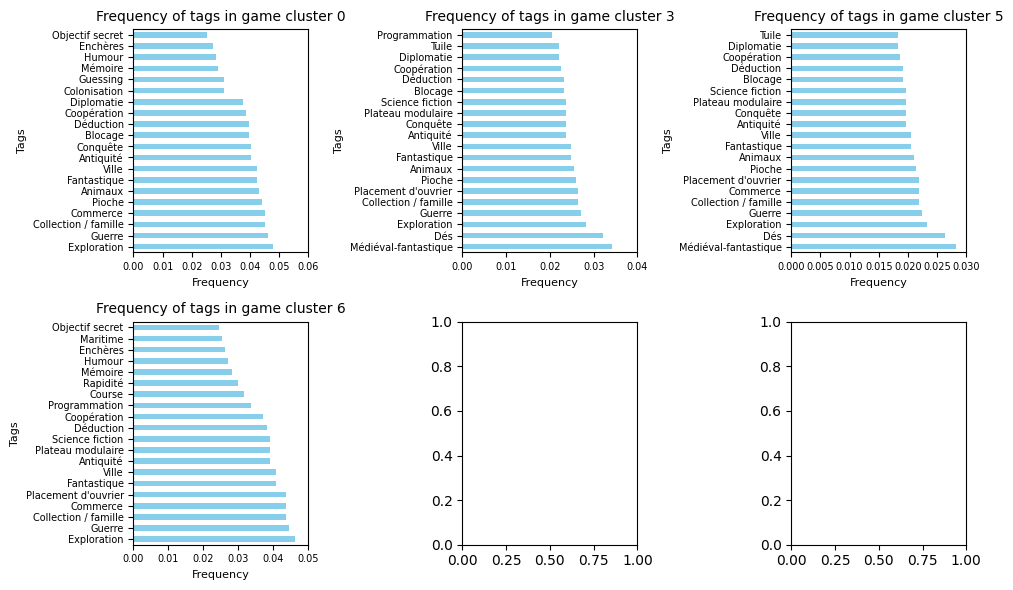

In [275]:
# cluster 0 3 5 6

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
clust_nb = [0, 3, 5, 6]
clust = 0
for i in range(3):
    for j in range(3):
        if clust >= len(clust_nb):
            break
        
        ax = axes[i, j]  # Get the axis for each subplot
        
        # Filter the DataFrame based on the current value of fl2 (clust)
        cluster_cat = game_type.loc[:, (game_type.loc[game_type.index[np.where(clustering.row_labels_ == clust_nb[clust])]] != 0).any(axis=0)]

        # Calculate the frequency of tags in the current cluster
        pop_tags = ["Jeux de plateau", "Jeux de cartes", "Hasard (Dé, Cartes, ...)", "Placement", "Affrontement", "Combinaison", "Gestion",
                    "Gestion de main", "Majorité", "Déplacement", "Bluff", "Médiéval", "Choix simultanés", "Prise de risque", "Ambiance"]
        cluster_cat = cluster_cat.drop(columns=pop_tags, errors='ignore')
        tag_frequency = (cluster_cat != 0).sum(axis=0) / (cluster_cat != 0).sum().sum()

        # Plot the frequency
        tag_frequency.nlargest(20).plot(kind='barh', color='skyblue', ax=ax)
        
        ax.set_title(f'Frequency of tags in game cluster {clust_nb[clust]}', fontsize=10)
        ax.set_xlabel('Frequency', fontsize=8) 
        ax.set_ylabel('Tags', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.set_xticks(ax.get_xticks())

        clust += 1

plt.tight_layout()
plt.show()

# cluster 0 and 6, cluster 3 and 5 are similar

In [47]:
# silhouette score evaluation game_type, co clustering
scores_users_tags = [
    (silhouette_score(game_type, model.row_labels_), silhouette_score(game_type.T, model.column_labels_)) for i in range(2, 10) for model in [SpectralCoclustering(n_clusters=i, random_state=0).fit(game_type)]]
scores_users_tags


[(0.7540042711634626, 0.4355406790396697),
 (0.7552111880500225, 0.4381909370503402),
 (0.5585077046423053, 0.3461045207415835),
 (0.688585407002384, 0.35789835558895833),
 (0.6769487975548539, 0.3602043088635917),
 (0.5309775687419583, 0.30895175306735867),
 (0.5239208317148963, 0.2944747509278556),
 (0.35735960441862274, 0.13810872008251737)]

#### Calculate the centroid of each cluster, and find the game closest to that point

In [276]:
# take back our 9 clusters
from sklearn.metrics import pairwise_distances

game_type["Cluster"] = clustering.row_labels_
game_type_old["Cluster"] = clustering.row_labels_
centroids = []

for clust in range(9): # find the game closest to the centroid of cluster
    # df_clust = game_type.loc[game_type.index[np.where(clustering.row_labels_ == clust)]]
    df_clust = game_type[game_type["Cluster"] == clust]
    df_clust_np = df_clust.to_numpy()

    centroid = np.mean(df_clust_np, axis = 0)
    centroids.append(centroid)
    centroid = centroid.reshape(1,-1)

    distances = pairwise_distances(df_clust_np, centroid).flatten() # eucl metric
    
    closest_game = game_type.loc[df_clust.index[np.argsort(distances)[0]]]

    # print(f"Cluster {clust} Game id {df_clust.index[np.argsort(distances)[0]]}, tags {closest_game[closest_game > 0].index} \n")


In [290]:
# recalculate frequency based on that
# freq of tags in the cluster with centroid ponderation in game type 
clust_freq_tags = []
for i in game_type["Cluster"].unique():
    df_clust = game_type[game_type["Cluster"] == i].drop(columns=["Cluster"])
    distances_pond = 1 / (pairwise_distances(df_clust, centroids[i][:-1].reshape(1, -1)).flatten() + 1e-6)
    df_clust = df_clust.mul(distances_pond, axis = 0) # ponderate
    freq = df_clust.mean(axis=0) 
    freq /= freq.sum()
    freq["Cluster"] = i
    clust_freq_tags.append(freq)

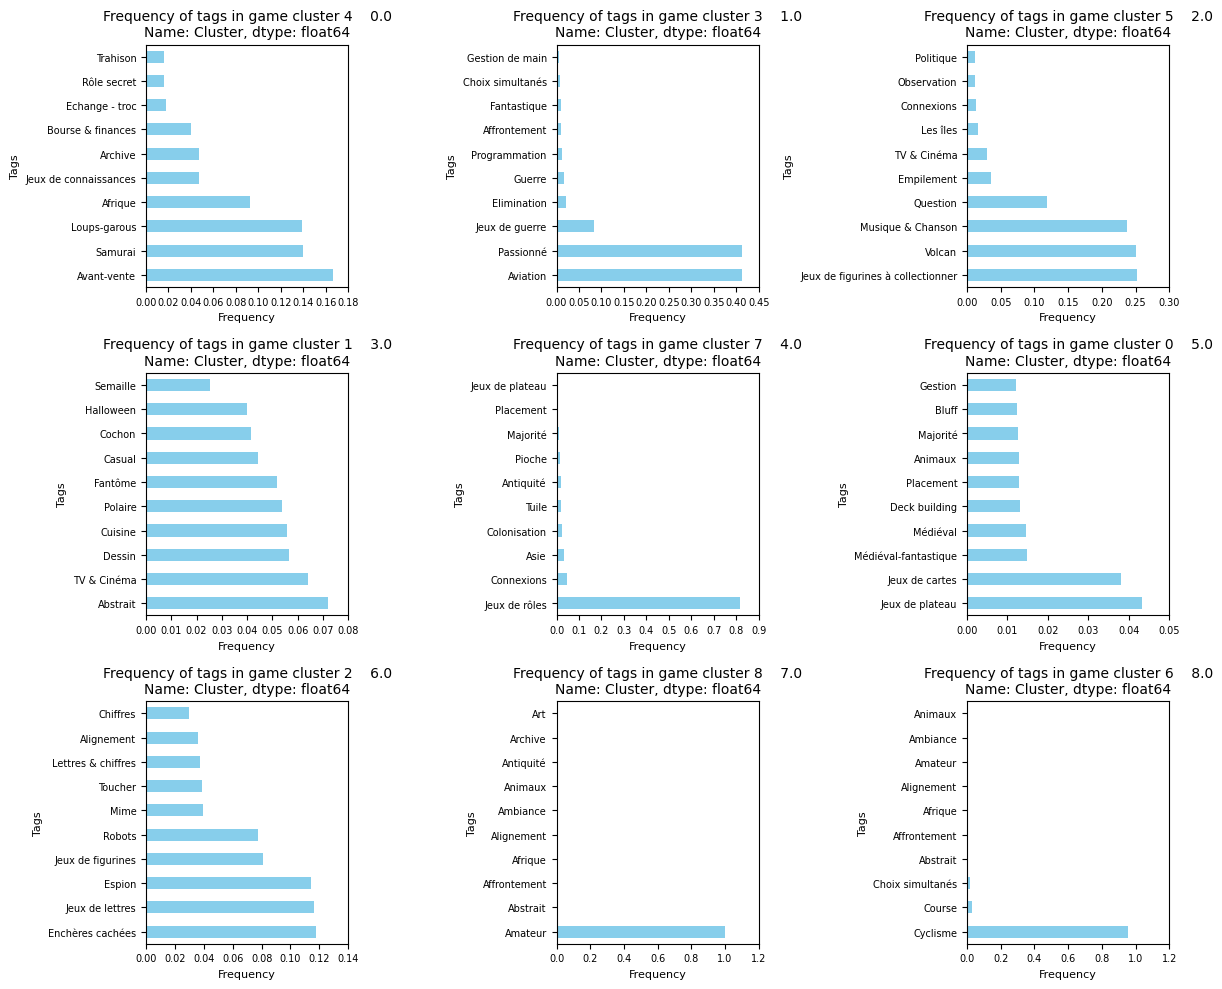

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

freq_df = pd.DataFrame(clust_freq_tags, columns=clust_freq_tags[0].index.to_numpy())

c = 0
for i in range(3):
    for j in range(3):
        ax = axes[i,j]  # Get the axis for each subplot
        freq_df[freq_df["Cluster"] == c].iloc[:,:-1].sum().nlargest(10).plot(kind='barh', color='skyblue', ax=ax)
        ax.set_title(f'Frequency of tags in game cluster {freq_df[freq_df["Cluster"] == c].iloc[:,-1]}', fontsize=10)
        ax.set_xlabel('Frequency', fontsize=8) 
        ax.set_ylabel('Tags', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.set_xticks(ax.get_xticks())
        c += 1

plt.tight_layout()
plt.show()


Let's apply PCA to reduce dimension in **game type** matrix, and project our clusters

In [190]:
# apply PCA to see the clusters
from sklearn.decomposition import PCA

Ncompo = 3
Ncluster = 3

pca = PCA(n_components=Ncompo)
user_type_2d = pca.fit_transform(game_type_old.drop(columns=["Cluster"]))


clustering = SpectralBiclustering(n_clusters=Ncluster, random_state=0).fit(user_type_2d) # on the games
game_type_old["Cluster"] = clustering.row_labels_

centroids = []
for clust in range(Ncluster): # find the game closest to the centroid of cluster
    df_clust = game_type_old[game_type_old["Cluster"] == clust]
    df_clust_np = df_clust.to_numpy()[:,:-1]
    centroid = np.mean(df_clust_np, axis = 0)
    centroids.append(centroid)
    centroid = centroid.reshape(1,-1)

    distances = pairwise_distances(df_clust_np, centroid).flatten() # eucl metric
    closest_game = game_type_old.loc[df_clust.index[np.argsort(distances)[0]]]

print(pca.explained_variance_ratio_)


[0.062039   0.05228523 0.04330267]


In [191]:
centroids_pca = pca.transform(centroids)

/home/franciline/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


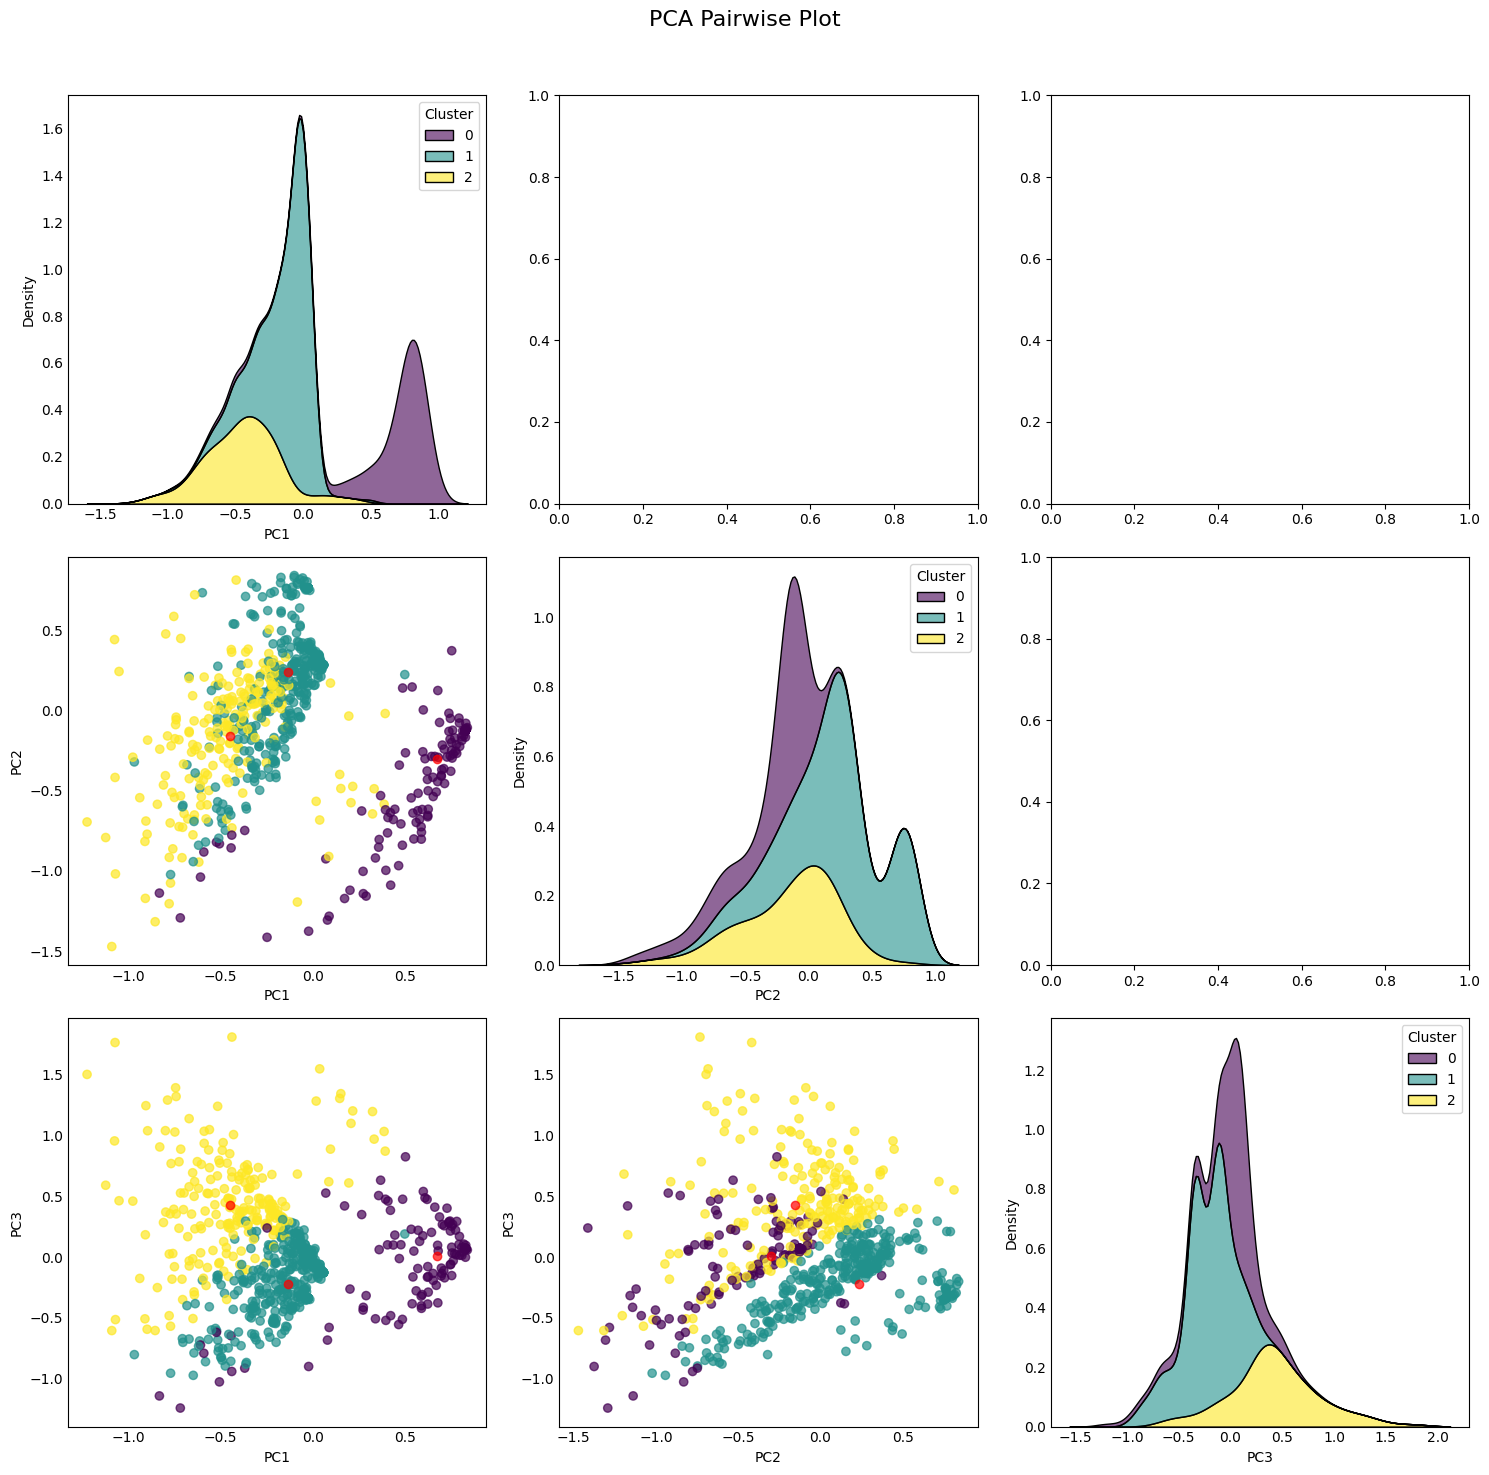

In [192]:
import seaborn as sns
fig, axes = plt.subplots(Ncompo, Ncompo, figsize=(15, 15))

pca_df = pd.DataFrame(user_type_2d, columns=[f'PC{i+1}' for i in range(Ncompo)])
pca_df['Cluster'] = clustering.row_labels_  # Add cluster labels to the DataFrame

# Loop through each pair of principal components 
for i in range(Ncompo):
    for j in range(i + 1):
        if i == j:
            sns.kdeplot(data=pca_df, x=f"PC{i+1}", multiple="stack", ax = axes[i, j], hue="Cluster", palette="viridis", alpha=0.6)
            ax.set_xlabel(f'PC{i+1}')
            ax.set_ylabel('Density')
        else:
            axes[i, j].scatter(user_type_2d[:, j], user_type_2d[:, i], alpha=0.7, c=clustering.row_labels_)
            axes[i, j].scatter(centroids_pca[:, j], centroids_pca[:, i], alpha=0.7, c='red')

            axes[i, j].set_xlabel(f'PC{j+1}')
            axes[i, j].set_ylabel(f'PC{i+1}')
        
        # Hide axis ticks 
        axes[i, j].tick_params(axis='both', which='both', length=0)
        
plt.suptitle('PCA Pairwise Plot', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to fit the suptitle
plt.show()

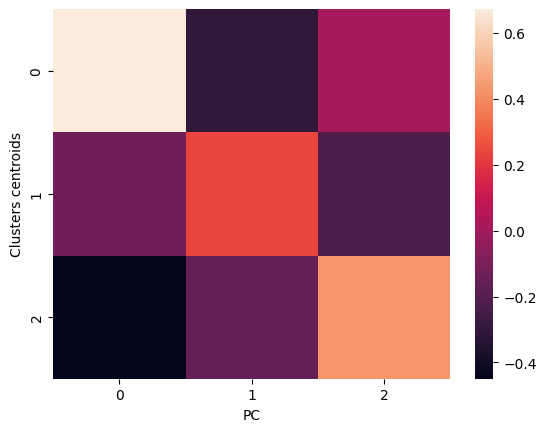

In [193]:
sns.heatmap(centroids_pca)
plt.xlabel('PC')
plt.ylabel('Clusters centroids')
plt.show()

In [ ]:
# freq of tags in the cluster with centroid ponderation in game type old
clust_freq_tags = []
for i in game_type_old["Cluster"].unique():
    df_clust = game_type_old[game_type_old["Cluster"] == i].drop(columns=["Cluster"])
    distances_pond = 1 / pairwise_distances(df_clust, centroids[i].reshape(1, -1)).flatten()
    df_clust = df_clust.mul(distances_pond, axis = 0) # ponderate
    freq = df_clust.mean(axis=0) 
    freq /= freq.sum()
    freq["Cluster"] = i
    clust_freq_tags.append(freq)


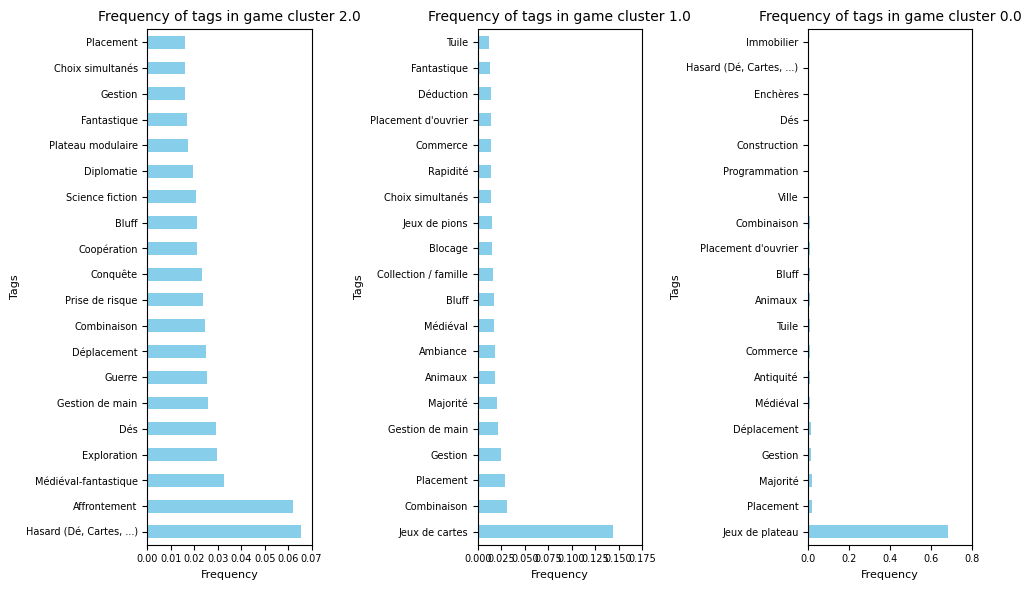

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

freq_df = pd.DataFrame(clust_freq_tags, columns=clust_freq_tags[0].index.to_numpy())

for j in range(3):
    ax = axes[j]  # Get the axis for each subplot
    
    freq_df.iloc[j,:-1].nlargest(20).plot(kind='barh', color='skyblue', ax=ax)
    
    ax.set_title(f'Frequency of tags in game cluster {freq_df.iloc[j,-1]}', fontsize=10)
    ax.set_xlabel('Frequency', fontsize=8) 
    ax.set_ylabel('Tags', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xticks(ax.get_xticks())

    clust += 1

plt.tight_layout()
plt.show()


---
## Clusters kmeans

### Users

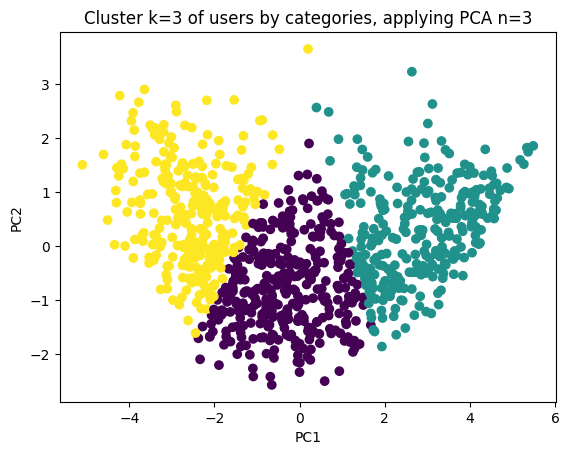

In [66]:
# apply PCA to see the clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
user_type_2d = pca.fit_transform(user_type)

# clustering the users
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3)  
clustered = kmeans.fit_predict(user_type_2d)

# plot view 1
plt.scatter(user_type_2d[:,0], user_type_2d[:,1], c=clustered)
plt.title("Cluster k=3 of users by categories, applying PCA n=3")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# plot view 2
# plt.scatter(user_type_2d[:,0], user_type_2d[:,2], c=clustered)
# plt.title("Cluster k=3 of users by categories, applying PCA n=2")
# plt.xlabel('PC1')
# plt.ylabel('PC3')

# plot view 3
# plt.scatter(user_type_2d[:,1], user_type_2d[:,2], c=clustered)
# plt.title("Cluster k=3 of users by categories, applying PCA n=2")
# plt.xlabel('PC2')
# plt.ylabel('PC3')
# plt.show()

We can see there aren't clusters among users. It won't be interesting to separate users on that.

### Games

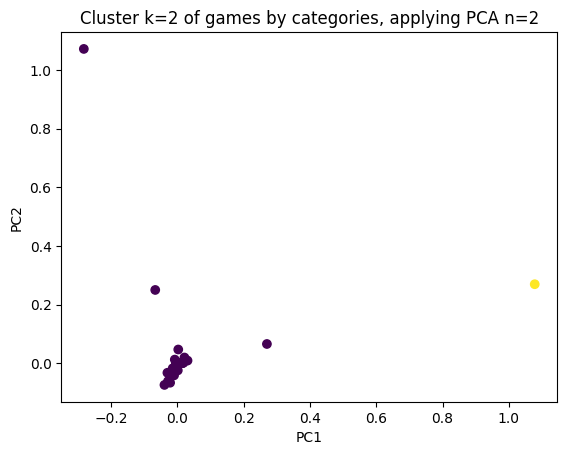

In [67]:
# apply PCA to see the clusters
pca = PCA(n_components=2)
game_type_2d = pca.fit_transform(game_type)

# clustering the games
# Perform K-Means clustering
kmeans = KMeans(n_clusters=2)  
clustered = kmeans.fit_predict(game_type_2d)

# plot view 1
plt.scatter(game_type_2d[:,0], game_type_2d[:,1], c=clustered)
plt.title("Cluster k=2 of games by categories, applying PCA n=2")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

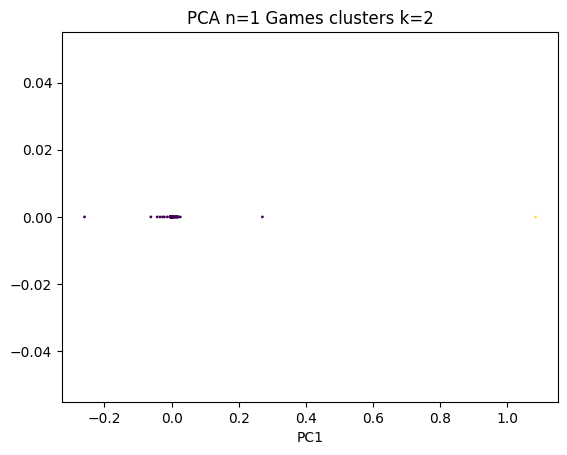

In [68]:
# visualisation in 1D
pca = PCA(n_components=1)
game_type_2d = pca.fit_transform(game_type)

fig = plt.figure()
plt.scatter(game_type_2d, np.zeros(len(game_type_2d)),c=clustered, s=1)
plt.title("PCA n=1 Games clusters k=2")
plt.xlabel('PC1')

plt.show()

In [69]:
# We inspect the tags associated to the games of both clusters to see what causes the separation 
class0 = np.where(clustered == 0)[0]
class1 = np.where(clustered == 1)[0]

# all tags associated to the games with count, choosing the most popular as the representant of the cluster
class0_label = game_type.iloc[class0].sum().sort_values(ascending=False).index[0]
class1_label =game_type.iloc[class1].sum().sort_values(ascending=False).index[0]

game_type.iloc[class0].sum().sort_values(ascending=False), game_type.iloc[class1].sum().sort_values(ascending=False)

(Type
 Hospitalier            1.000000
 Maritime               1.000000
 Lettres & chiffres     1.000000
 Levées                 1.000000
 Locomotion & voyage    1.000000
                          ...   
 Monstre                1.000000
 Politique              0.952381
 TV & Cinéma            0.875000
 Question               0.500000
 Musique & Chanson      0.000000
 Length: 155, dtype: float64,
 Type
 Musique & Chanson    1.000000
 Question             0.500000
 TV & Cinéma          0.125000
 Politique            0.047619
 Maritime             0.000000
                        ...   
 Dés                  0.000000
 Echange - troc       0.000000
 Egypte               0.000000
 Elimination          0.000000
 équipe               0.000000
 Length: 155, dtype: float64)

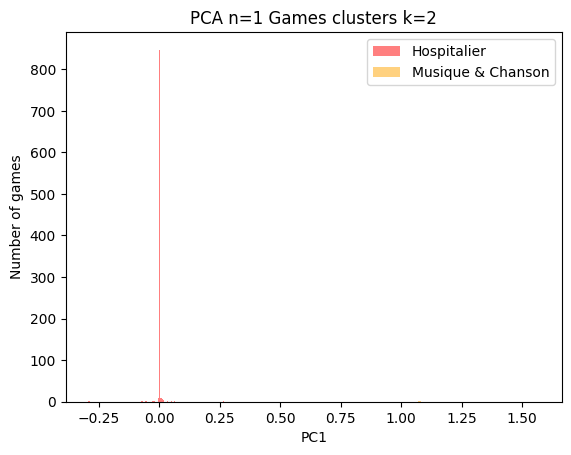

In [70]:
# visualisation 
pca = PCA(n_components=1)
game_type_2d = pca.fit_transform(game_type)

fig = plt.figure()
plt.hist(game_type_2d[np.where(clustered == 0)[0]], bins=100, color="red", alpha=0.5, label=class0_label)
plt.hist(game_type_2d[np.where(clustered == 1)[0]], bins=100, color="orange", alpha=0.5, label=class1_label)
plt.title("PCA n=1 Games clusters k=2")
plt.xlabel('PC1')
plt.ylabel("Number of games")
plt.legend()
plt.show()

In [71]:
# verify the matrix is working okay
# tmp2[tmp2["User id"] == 0]['Type'].unique().shape
# np.unique([el for sub in avis_jeux[avis_jeux["User id"] == 0]["Type"].str.split(r'[|/]').tolist() for el in sub]).shape
# user_type.loc[0].sum()
# len(user_game_type[user_game_type["User id"] == 1]["Type"].unique())

## Bi clustering/Co Clustering

In [72]:
# for reordering columns
# original_columns = user_type.columns
# original_rows = user_type.index
# new_column_order = np.argsort(clustering.column_labels_)
# new_row_order = np.argsort(clustering.row_labels_)

# Mapping new order to original columns
# reordered_column_names = original_columns[new_column_order]
# reordered_row_names = original_rows[new_row_order]
# # print("original", original_rows)
# print("new",reordered_row_names)

In [73]:
from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model to the user-item matrix (after filling NaN values)
gmm = GaussianMixture(n_components=5, random_state=0)
user_clusters = gmm.fit_predict(user_game_ratings.toarray())

# Now user_clusters contains the soft cluster assignments (users can belong to multiple clusters)
user_clusters

array([3, 2, 1, 4, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 4, 3, 3, 2, 3, 4,
       3, 1, 3, 2, 4, 4, 0, 1, 4, 1, 0, 0, 3, 4, 4, 1, 1, 4, 4, 3, 3, 1,
       1, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       4, 4, 4, 3, 4, 1, 3, 0, 4, 1, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 1, 4, 0, 3, 3, 3, 3, 1, 4, 3, 3,
       3, 4, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 4, 3, 0, 1, 0, 4, 1, 4, 0,
       0, 1, 3, 4, 4, 4, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 4, 3, 3, 3, 4, 1, 1, 3,
       0, 3, 3, 3, 3, 3, 4, 4, 4, 1, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3,
       3, 0, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 0,
       1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 0, 0, 4, 4, 1, 4, 1, 1, 1, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 1, 1, 3, 3,
       3, 3, 3, 4, 3, 4, 3, 3, 1, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 1,
       3, 3, 3, 0, 4, 3, 3, 3, 3, 3, 3, 4, 1, 4, 0,

Counter({3: 644, 1: 119, 4: 99, 0: 43, 2: 8})

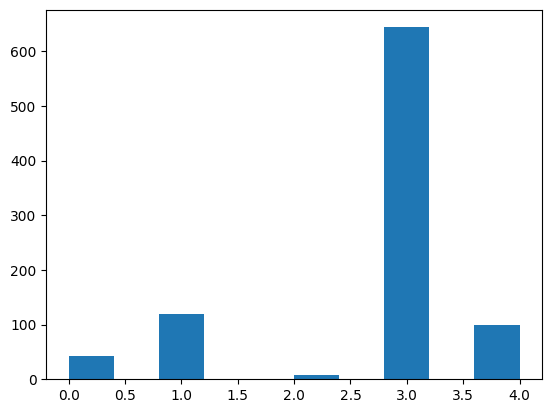

In [74]:
plt.hist(user_clusters)
from collections import Counter
Counter(user_clusters)